In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [17]:
df = pd.read_csv("../car_prices.csv")
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [3]:
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)
df['month'] = df['saledate'].dt.month
sales_data = df.groupby(['make', 'model', 'month']).agg({'sellingprice': 'count'}).reset_index()
sales_data.rename(columns={'sellingprice': 'sales_count'}, inplace=True)
df = pd.merge(sales_data, df, on=['make', 'model', 'month'], how='left')

C:\Users\davyd\AppData\Local\Temp\ipykernel_9024\3620098811.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce', utc=True)


In [4]:
df.head()

,make,model,month,sales_count,year,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,Acura,CL,1.0,20,1997,3.0 Premium,Coupe,NaN,19uya2257vl017017,tx,3.0,128464.0,blue,gray,capital auto auction,1350.0,1300.0,2015-01-12 19:00:00+00:00
1,Acura,CL,1.0,20,2001,3.2 Type-S,Coupe,automatic,19uya42741a026776,ca,25.0,232664.0,white,tan,consolidated asset recovery systems inc.,1200.0,450.0,2015-01-14 20:30:00+00:00
2,Acura,CL,1.0,20,2001,3.2,Coupe,automatic,19uya424x1a004920,md,2.0,203612.0,silver,black,ourisman of clarksville inc,1325.0,900.0,2015-01-06 01:30:00+00:00
3,Acura,CL,1.0,20,2001,3.2,Coupe,automatic,19uya42441a021518,md,27.0,98958.0,gold,beige,sheehy nissan,2150.0,3500.0,2015-01-13 01:30:00+00:00
4,Acura,CL,1.0,20,1998,3.0 Premium,Coupe,automatic,19uya2251wl013255,fl,2.0,84549.0,black,black,autonation honda clearwater,1050.0,2200.0,2015-01-13 02:00:00+00:00


In [5]:
df = df.drop(["vin", "mmr", "state", "seller", "saledate", "trim"], axis = 1)


In [6]:
num = df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()
categ = [col for col in df.columns if col not in num]

print(num)
print(categ)

['month', 'sales_count', 'year', 'condition', 'odometer', 'sellingprice']
['make', 'model', 'body', 'transmission', 'color', 'interior']


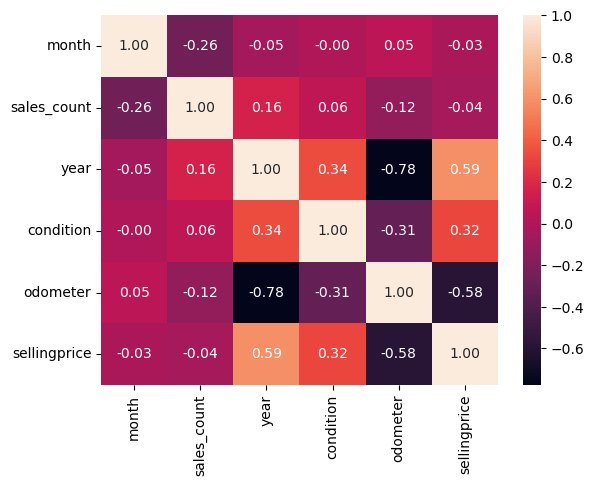

In [7]:
sns.heatmap(df[num].corr(), annot=True, fmt='.2f')
plt.show()

In [8]:
def remove_outliers(df):
    df_cleaned = df.copy()
    for col in num:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] > lower_bound) & (df_cleaned[col] < upper_bound)]
    return df_cleaned

print(df.shape)
df = remove_outliers(df)
print(df.shape)

(548400, 12)
(470957, 12)


In [9]:
df = df.dropna()

In [10]:
X = df.drop('sales_count', axis=1)  
y = df['sales_count']  
num.remove("sales_count")

In [11]:
X = pd.get_dummies(X, columns=categ, drop_first=True)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [13]:
print(X.isna().sum().sum(), X_train.isna().sum().sum())

0 0


In [14]:
X_train.shape, X_test.shape

((395046, 821), (20792, 821))

In [15]:
scaler = StandardScaler()
X_train[num] = pd.DataFrame(scaler.fit_transform(X_train[num]), index=X_train.index, columns=num)
X_test[num] = pd.DataFrame(scaler.transform(X_test[num]), index=X_test.index, columns=num)

In [16]:
from keras.layers import InputLayer, Dense
from keras.models import Sequential
from keras.optimizers import Adam


model_nn = Sequential([
    InputLayer((X_train.shape[1],)),
    Dense(64, "relu"),
    Dense(32, "relu"),
    Dense(16, "relu"),
    Dense(1)
])

model_nn.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')
model_nn.fit(X_train, y_train, epochs=5, batch_size=32) 

y_pred = model_nn.predict(X_test)
y_pred_train = model_nn.predict(X_train)

r2_val = round(r2_score(y_test, y_pred), 4)
rmse_val = round(np.sqrt(mean_squared_error(y_test, y_pred)))

r2_train = round(r2_score(y_train, y_pred_train), 4)
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)))

print(r2_val, rmse_val)
print(r2_train, rmse_train)

#model_results(y_pred, y_pred_train)

ModuleNotFoundError: No module named 'keras'